<a href="https://colab.research.google.com/github/s2ul2/bitamin/blob/main/2%EC%A1%B0_RNN_%EB%B3%B5%EC%8A%B5%EB%AC%B8%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 순차데이터와 RNN의 기본구조

## 1. 순차데이터의 특징 3가지는?

정답: 
1. 특징이 나타나는 순서가 중요하다
2. 샘플마다 입력차원의 길이가 다르다.
3. 문맥에 의존한다.

## 2. RNN이 시간성, 가변길이, 문맥의존성을 모두 처리하기 위해 은닉층이 가지는 연결로, t-1 순간에 발생한 정보를 t순간으로 전달 가능케 하는 것은?

정답: hidden state

# 2. PyTorch RNN(빈칸 채우기문제)
복습과제 폴더에 포함되어 같이 제공되는 PyTorch_RNN_과제.ipynb를 참고해주세요.

죄송합니다. 시간이 없어서 못했습니다. ㅜㅜ

## 3. BPTT 개념문제
1. RNN은 순환 구조를 띄는 신경망이기 때문에 하단의 그림에서 〖𝑑ℎ〗(𝑡−1) 은 t-1 시점의 Loss에서 흘러들어온 그래디언트 뿐 아니라 ⭐️에 해당하는 그래디언트가 더해집니다. ⭐️이 의미하는 것을 수식으로 표현해주세요. (힌트 : h(t-1)= *)

**사진이 잘 안보인다면 발표자료pdf 32쪽 그림을 참고해주세요!
<img src='p1.png' width='400px' height='300px'></img>

답 : W_xh * x_t

2. BPTT와 Truncated BPTT의 단점을 설명하고 이를 보완하는 방법을 설명해주세요.

답: Gradient Vanishing 문제 --> LSTM 사용

## 4.  RNN을 사용해 주식가격의 변동 예측하기

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/비타민/2학기/3week_RNN/복습과제

/content/drive/MyDrive/비타민/2학기/3week_RNN/복습과제


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential

In [5]:
# 데이터 불러오기
samsung = pd.read_csv("samsung.csv", index_col=0)
samsung

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4675.782715,74195000
2000-01-05,5800.0,6060.0,5520.0,5580.0,4270.191895,74680000
2000-01-06,5750.0,5780.0,5580.0,5620.0,4300.801758,54390000
2000-01-07,5560.0,5670.0,5360.0,5540.0,4239.581055,40305000
2000-01-10,5600.0,5770.0,5580.0,5770.0,4415.591309,46880000
...,...,...,...,...,...,...
2017-06-26,47520.0,48360.0,47520.0,48280.0,42038.109375,8552800
2017-06-27,48220.0,48400.0,47900.0,48300.0,42055.515625,9616750
2017-06-28,47600.0,48000.0,47560.0,47700.0,41533.097656,9572500


In [6]:
samsung.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4423 entries, 2000-01-04 to 2017-06-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4423 non-null   float64
 1   High       4423 non-null   float64
 2   Low        4423 non-null   float64
 3   Close      4423 non-null   float64
 4   Adj Close  4423 non-null   float64
 5   Volume     4423 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 241.9+ KB


In [7]:
samsung.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4423.000000,4423.000000,4423.000000,4423.000000,4423.000000,4.423000e+03
mean,15930.510965,16104.872259,15757.399955,15934.141985,12929.152827,2.352588e+07
std,9335.341841,9412.066133,9266.702969,9343.505417,8102.258153,1.640211e+07
min,2540.000000,2760.000000,2420.000000,2730.000000,2089.180176,0.000000e+00
25%,8965.000000,9050.000000,8820.000000,8930.000000,6865.008301,1.267628e+07
50%,12600.000000,12760.000000,12480.000000,12600.000000,9681.326172,1.941200e+07
75%,24610.000000,24940.000000,24410.000000,24600.000000,20358.583984,2.961750e+07
max,48220.000000,48400.000000,47940.000000,48300.000000,42055.515625,1.642150e+08


In [8]:
samsung.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
high_prices = samsung['High'].values
low_prices = samsung['Low'].values
mid_prices = (high_prices+low_prices)/2
mid_prices

#중간 값 요소 추가하기
samsung['Mid'] = mid_prices
samsung

#Close 제거
samsung.drop("Close", axis=1,inplace=True)

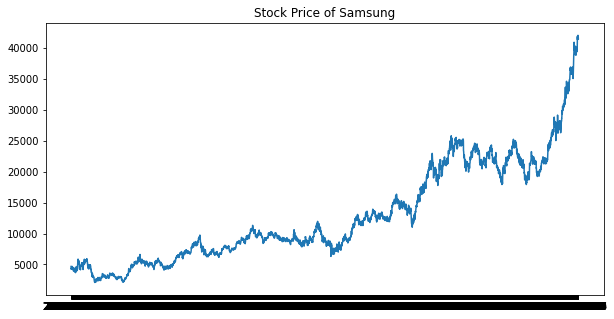

In [10]:
plt.figure(figsize=(10,5))
plt.plot(samsung['Adj Close'])
plt.title("Stock Price of Samsung")
plt.show()

In [11]:
#데이터 스케일링 

samsung_minimum = samsung['Adj Close'].min()
samsung_maximum = samsung['Adj Close'].max()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
samsung_scaled = scaler.fit_transform(samsung)
samsung = pd.DataFrame(samsung_scaled, columns=samsung.columns, index=list(samsung.index.values))
samsung

,Open,High,Low,Adj Close,Volume,Mid
2000-01-04,0.075744,0.073401,0.071178,0.064720,0.451816,0.072322
2000-01-05,0.071366,0.072305,0.068102,0.054571,0.454770,0.070237
2000-01-06,0.070271,0.066170,0.069420,0.055337,0.331212,0.067823
2000-01-07,0.066112,0.063760,0.064587,0.053805,0.245440,0.064201
2000-01-10,0.066988,0.065951,0.069420,0.058209,0.285479,0.067713
...,...,...,...,...,...,...
2017-06-26,0.984676,0.999124,0.990773,0.999564,0.052083,0.995391
2017-06-27,1.000000,1.000000,0.999121,1.000000,0.058562,1.000000
2017-06-28,0.986427,0.991236,0.991652,0.986929,0.058292,0.991879
2017-06-29,0.996060,0.998247,1.000000,0.995232,0.050583,0.999561


In [12]:
# train/test set 나누기
# 앞에서부터 90%의 데이터를 train set으로, 나머지 10%를 test set으로 사용
train_size = int(len(samsung)*0.9)
X_train = np.array(samsung.drop('Adj Close', axis=1)[:train_size])
y_train = np.array(samsung['Adj Closea'][:train_size])

X_test =np.array(samsung.drop("Adj Close", axis=1)[train_size:])
y_test = np.array(samsung['Adj Close'][train_size:])

In [13]:
print(f"shape of X_train: {X_train.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of X_test: {X_test.shape}")
print(f"shape of y_test: {y_test.shape}")

shape of X_train: (3980, 5)
shape of y_train: (3980,)
shape of X_test: (443, 5)
shape of y_test: (443,)


### 문제4-1 아래와 같이 데이터의 구조를 바꿔주는 이유를 간단하게 설명해주세요. 만약, MLP를 사용해서 이 데이터를 분석하려고 한다면 데이터의 구조를 어떻게 해야 할까요

In [18]:
# 구조 바꾸기
input_size = 5
X_train = X_train.reshape(X_train.shape[0], 1 , input_size)
X_test = X_test.reshape(X_test.shape[0],1, input_size)
print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_test: {X_test.shape}")

shape of X_train: (3980, 1, 5)
shape of X_test: (443, 1, 5)


데이터의 구조를 바꿔주는 이유: RNN은 3D 텐서를 입력받기 때문

MLP를 사용할 시 데이터의 구조: 

### 문제 4-2 주어진 설명에 맞춰 빈 부분을 채워 모델 구조를 완성해 주세요

In [20]:
# 모델 구조 설정
model = Sequential()
model.add(SimpleRNN(1000, input_shape=(1, 5))) # units=1000으로 설정하고, 적절한 input_shape를 찾아 값을 넣어주세요.
model.add(Dense(1,activation='tanh')) 
model.add(Dropout(0.25)) #Dropout 레이어를 추가해주세요. Dropout비율은 0.25로 설정해주세요

callbacks = [EarlyStopping(monitor = 'val_loss', patience=5), #기준 값이 연속으로 5 번 이상 향상되지 않을 때 종료하도록 설정하세요
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_model=True)] # 이전보다 성능이 향상이 모델을 저장할 수 있도록 설정하세요.
model.compile(optimizer='sgd', loss='mse', metrics=['mae', 'mse']) # optimizer를 sgd으로, loss를 mse로 설정해주세요.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 1000)              1006000   
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
Total params: 1,007,001
Trainable params: 1,007,001
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train, epochs=500, batch_size=100, verbose=0, #훈련과정이 출력되지 않도록 설정하세요
                  validation_split =0.2,callbacks=callbacks)  # Train 데이터 셋의 20%를 validation 셋으로 사용하도록 설정하세요

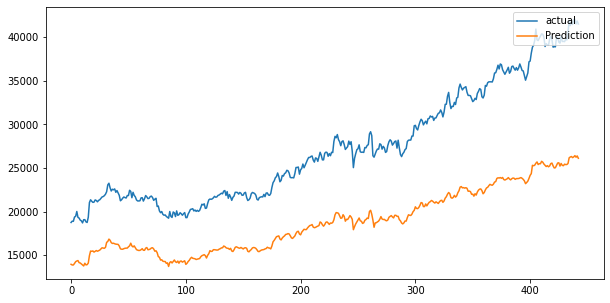

In [22]:
# 예측 결과 확인하기
predictions = model.predict(X_test)

predictions_unscaled = predictions * (samsung_maximum-samsung_minimum) +samsung_minimum
y_test_unscaled = y_test * (samsung_maximum-samsung_minimum) +samsung_minimum

plt.figure(figsize=(10,5))
plt.plot(y_test_unscaled, label='actual')
plt.plot(predictions_unscaled, label='Prediction')
plt.legend(loc='upper right')
plt.show()